<a href="https://colab.research.google.com/github/CeciliaMarson/CMLS-Homework1/blob/master/Copy_of_GenreClassification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genre Classification using Support-vector Machine

In [0]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import sklearn.svm
import IPython.display as ipd
import scipy as sp

In [2]:
!wget --no-check-certificate -r "https://drive.google.com/uc?export=download&confirm=yZOu&id=1bN4JQLwy2nLGkhGQG8IgK-u8TIl2A9Rf" -O "Input.zip" 

will be placed in the single file you specified.

--2020-04-13 09:43:09--  https://drive.google.com/uc?export=download&confirm=yZOu&id=1bN4JQLwy2nLGkhGQG8IgK-u8TIl2A9Rf
Resolving drive.google.com (drive.google.com)... 173.194.214.100, 173.194.214.138, 173.194.214.101, ...
Connecting to drive.google.com (drive.google.com)|173.194.214.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Input.zip’

Input.zip               [ <=>                ]   3.19K  --.-KB/s    in 0s      

2020-04-13 09:43:09 (27.6 MB/s) - ‘Input.zip’ saved [3264]

Loading robots.txt; please ignore errors.
--2020-04-13 09:43:09--  https://drive.google.com/robots.txt
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘Input.zip’

Input.zip               [ <=>                ]     570  --.-KB/s    in 0s      

2020-04-13 09:43:09 (73.1 MB/s) - ‘Input.zip’ saved [570]

In [3]:
!unzip Input.zip

Archive:  Input.zip
warning [Input.zip]:  403061 extra bytes at beginning or within zipfile
  (attempting to process anyway)
   creating: Input/
  inflating: __MACOSX/._Input        
  inflating: Input/.DS_Store         
  inflating: __MACOSX/Input/._.DS_Store  
   creating: Input/metal/
  inflating: __MACOSX/Input/._metal  
   creating: Input/disco/
  inflating: __MACOSX/Input/._disco  
   creating: Input/blues/
  inflating: __MACOSX/Input/._blues  
  inflating: Input/metal/.DS_Store   
  inflating: __MACOSX/Input/metal/._.DS_Store  
   creating: Input/metal/test/
  inflating: __MACOSX/Input/metal/._test  
   creating: Input/metal/training/
  inflating: __MACOSX/Input/metal/._training  
  inflating: Input/disco/.DS_Store   
  inflating: __MACOSX/Input/disco/._.DS_Store  
   creating: Input/disco/test/
  inflating: __MACOSX/Input/disco/._test  
   creating: Input/disco/training/
  inflating: __MACOSX/Input/disco/._training  
  inflating: Input/blues/.DS_Store   
  inflating: __MACOSX/I

# Feature computation

In [0]:
def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal
    X = np.abs(librosa.stft(
        audio,
        window='hamming',
        n_fft=1024,
        hop_length=512,)
        )
    
    # Find the weights of the mel filters
    mel = librosa.filters.mel(
        sr=fs,
        n_fft=1024,
        n_mels=40,
        fmin=133.33,
        fmax=6853.8,
    )
    # Apply the filters to spectrogram
    melspectrogram = np.dot(mel, X)
    # Take the logarithm
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc+1]
    return mfcc

### Compute training features

In [0]:
classes = ['blues', 'disco', 'metal']
n_mfcc = 13
dict_train_features = {'blues': [], 'metal': [], 'disco': []}

for c in classes:
    train_root = 'Input/{}/training/'.format(c)
    class_train_files = [f for f in os.listdir(train_root) if f.endswith('.wav')]
    n_train_samples = len(class_train_files)
    
    train_features = np.zeros((n_train_samples, n_mfcc))
    for index, f in enumerate(class_train_files):
        audio, fs = librosa.load(os.path.join(train_root, f), sr=None)
        mfcc = compute_mfcc(audio, fs, n_mfcc)
        train_features[index, :] = np.mean(mfcc, axis=1)

    dict_train_features[c] = train_features

In [6]:
ipd.Audio(audio, rate=fs) # load a local WAV file

### Compute test features

In [0]:
dict_test_features = {'blues': [], 'metal': [], 'disco': []}

for c in classes:
    test_root = 'Input/{}/test/'.format(c)
    class_test_files = [f for f in os.listdir(test_root) if f.endswith('.wav')]
    n_test_samples = len(class_test_files)
    
    test_features = np.zeros((n_test_samples, n_mfcc))
    for index, f in enumerate(class_test_files):
        audio, fs = librosa.load(os.path.join(test_root, f), sr=None)
        mfcc = compute_mfcc(audio, fs, n_mfcc)
        test_features[index, :] = np.mean(mfcc, axis=1)
    dict_test_features[c] = test_features

### Feature visualization

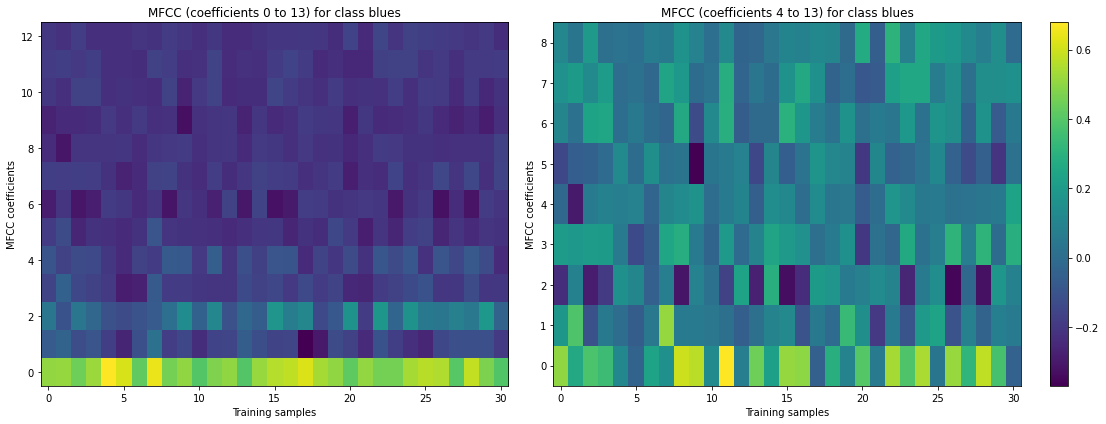

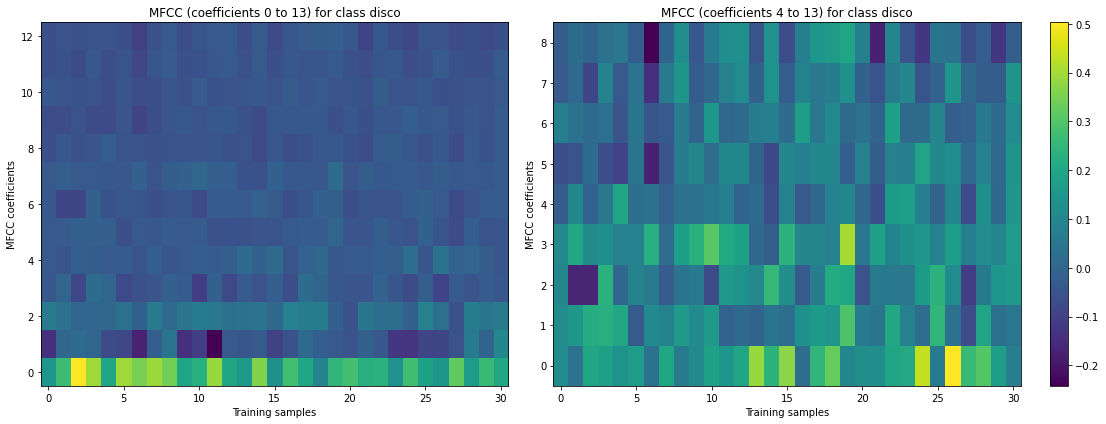

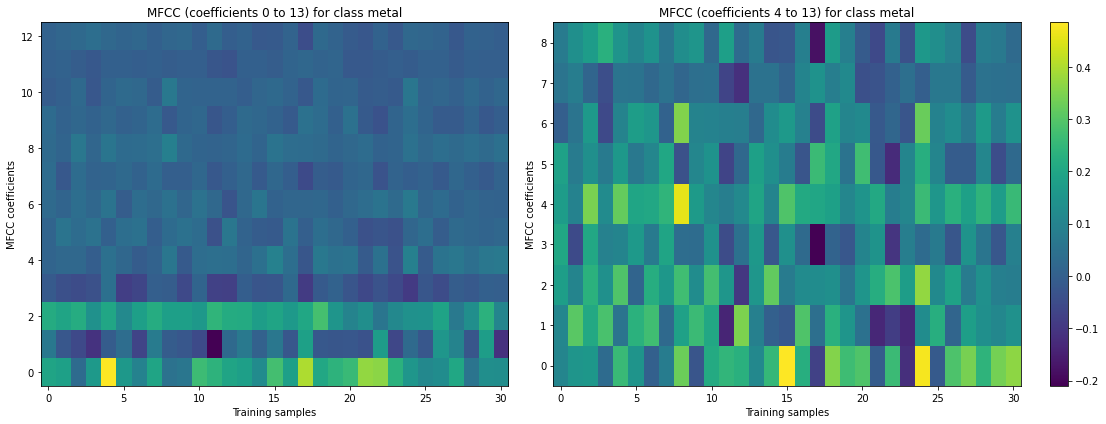

In [0]:
for c in classes:
    mfcc = dict_train_features[c].transpose()
    # Visualization
    fig = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 13) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()

    mfcc_upper = mfcc[4:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 4 to 13) for class {}'.format(c))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.tight_layout()

# SVM : binary case

## Classification on 2 classes

In [0]:
class_0 = 'metal'
class_1 = 'disco'

X_train_0 = dict_train_features[class_0]
X_train_1 = dict_train_features[class_1]

X_train = np.concatenate((X_train_0, X_train_1), axis=0)

y_train_0 = np.zeros((X_train_0.shape[0],))
y_train_1 = np.ones((X_train_1.shape[0],))

y_train = np.concatenate((y_train_0, y_train_1), axis=0)


In [0]:
X_test_0 = dict_test_features[class_0]
X_test_1 = dict_test_features[class_1]

X_test = np.concatenate((X_test_0, X_test_1), axis=0)

y_test_0 = np.zeros((X_test_0.shape[0],))
y_test_1 = np.ones((X_test_1.shape[0],))

y_test = np.concatenate((y_test_0, y_test_1), axis=0)

### *Exercise 1*: Normalize features for two classes
Normalize the features in <code>X_train</code> and <code>X_test</code>. What kind of normalization would you use for SVM?

**Hints**
- remember to normalize along the time dimension
- normalization parameters should be computed on train only and then used on both train and test set

In [0]:
feat_max = np.max(X_train, axis=0)
feat_min = np.min(X_train, axis=0)
X_train_normalized = (X_train - feat_min) / (feat_max - feat_min)
X_test_normalized = (X_test - feat_min) / (feat_max - feat_min)


### *Exercise 2*:  Define and train the model
Take a look at sklearn documentation for [ Support Vector Machine Classifier ](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). If you want, choose some parameters for the SVM classifier definition.

**Hints**:
-  to train the model use  [<code>model.fit</code>](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.fit) function: which are the correct arguments to the function call?

In [0]:
SVM_parameters={
    'C': 1,
    'kernel': 'rbf',
}

clf = sklearn.svm.SVC(**SVM_parameters)

In [0]:
clf.fit(X_train_normalized, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Evaluation

In [0]:
def compute_metrics(gt_labels, predicted_labels):
    TP = np.sum(np.logical_and(predicted_labels == 1, gt_labels == 1))
    FP = np.sum(np.logical_and(predicted_labels == 1, gt_labels == 0))
    TN = np.sum(np.logical_and(predicted_labels == 0, gt_labels == 0))
    FN = np.sum(np.logical_and(predicted_labels == 0, gt_labels == 1))
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2 * precision * recall / (precision + recall)
    print("Results : \n accuracy = {} \n precision = {} \n recall = {} \n F1 score = {}".format(
        accuracy, precision, recall, F1_score))


In [0]:
y_test_predicted = clf.predict(X_test_normalized)

compute_metrics(y_test, y_test_predicted)

Results : 
 accuracy = 0.8333333333333334 
 precision = 0.8125 
 recall = 0.8666666666666667 
 F1 score = 0.8387096774193549


# SVM: multiclass case

In [0]:
class_0 = 'blues'
class_1 = 'disco'
class_2 = 'metal'

X_train_0 = dict_train_features[class_0]
X_train_1 = dict_train_features[class_1]
X_train_2 = dict_train_features[class_2]

y_train_0 = np.zeros((X_train_0.shape[0],))
y_train_1 = np.ones((X_train_1.shape[0],))
y_train_2 = np.ones((X_train_2.shape[0],))*2



In [0]:
X_test_0 = dict_test_features[class_0]
X_test_1 = dict_test_features[class_1]
X_test_2 = dict_test_features[class_2]


y_test_0 = np.zeros((X_test_0.shape[0],))
y_test_1 = np.ones((X_test_1.shape[0],))
y_test_2 = np.ones((X_test_2.shape[0],))*2

y_test_mc = np.concatenate((y_test_0, y_test_1, y_test_2), axis=0)


### Normalize features

In [0]:
feat_max = np.max(np.concatenate((X_train_0, X_train_1, X_train_2), axis=0), axis=0)
feat_min = np.min(np.concatenate((X_train_0, X_train_1, X_train_2), axis=0), axis=0)

X_train_0_normalized = (X_train_0 - feat_min) / (feat_max - feat_min)
X_train_1_normalized = (X_train_1 - feat_min) / (feat_max - feat_min)
X_train_2_normalized = (X_train_2 - feat_min) / (feat_max - feat_min)

X_test_0_normalized = (X_test_0 - feat_min) / (feat_max - feat_min)
X_test_1_normalized = (X_test_1 - feat_min) / (feat_max - feat_min)
X_test_2_normalized = (X_test_2 - feat_min) / (feat_max - feat_min)

X_test_mc_normalized = np.concatenate((X_test_0_normalized, X_test_1_normalized, X_test_2_normalized), axis=0)


### Define and train a model for each couple of classes

In [0]:
SVM_parameters={
    'C': 1,
    'kernel': 'rbf',
}

clf_01 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_02 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_12 = sklearn.svm.SVC(**SVM_parameters, probability=True)


In [0]:
clf_01.fit(np.concatenate((X_train_0_normalized, X_train_1_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_1), axis=0))
           
clf_02.fit(np.concatenate((X_train_0_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_2), axis=0))

clf_12.fit(np.concatenate((X_train_1_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_1, y_train_2), axis=0))

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### Evaluate each classifier

In [0]:
y_test_predicted_01 = clf_01.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_02 = clf_02.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_12 = clf_12.predict(X_test_mc_normalized).reshape(-1, 1)

### Majority voting

In [0]:
y_test_predicted_mc = np.concatenate((y_test_predicted_01, y_test_predicted_02, y_test_predicted_12), axis=1)
y_test_predicted_mc = np.array(y_test_predicted_mc, dtype=np.int)

In [0]:
y_test_predicted_mv = np.zeros((y_test_predicted_mc.shape[0],))
for i, e in enumerate(y_test_predicted_mc):
    y_test_predicted_mv[i] = np.bincount(e).argmax() 

### *Exercise 3* : Compute confusion matrix for multiclass
Compute and print the confusion matrix when more than 2 classes are presents.

In [0]:
def compute_cm_multiclass(gt, predicted):
    classes = np.unique(gt)
    
    CM = np.zeros((len(classes), len(classes)))
    
    for i in np.arange(len(classes)):
        pred_class = predicted[gt==i]
        
        for j in np.arange(len(pred_class)):
            CM[i, int(pred_class[j])] = CM[i, int(pred_class[j])] + 1 
    print(CM)

In [0]:
compute_cm_multiclass(y_test_mc, y_test_predicted_mv)

[[11.  4.  0.]
 [ 0. 13.  2.]
 [ 0.  4. 11.]]
